In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as log_progress

from skimage.data import shepp_logan_phantom

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [25]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        print("coords = ", coords.shape)
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [27]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [28]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [34]:
import cv2
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        #blur_noisy_img
        #img = get_cameraman_tensor(sidelength)
        #img = blur_noisy_img
        img = cv2.resize(blur_noisy_img, (256, 256), interpolation=cv2.INTER_AREA)
        print(img.shape)
        self.pixels = img#img.permute(1, 2, 0).view(-1, 1)
        self.coords = img #get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [30]:
# cameraman = ImageFitting(256)
# dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

# img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
#                   hidden_layers=3, outermost_linear=True)
# img_siren.cuda()

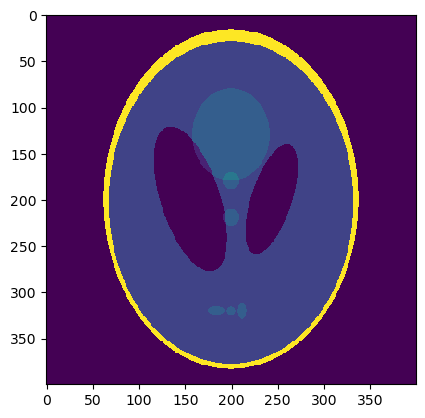

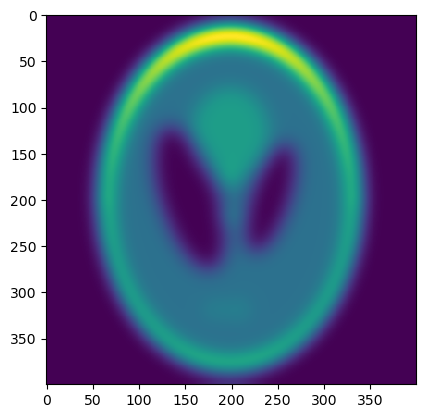

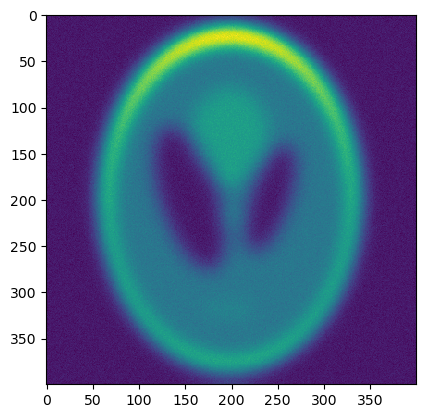

In [31]:
#LIA'S IMAGE PHANTOM STUFF

# Show image info
def img_info(im):
    print(f'type: {type(im)}\ndtype: {im.dtype}\nsmallest pixel value: {np.min(im)}\nlargest pixel value: {np.max(im)}')

# load an image
img = torch.from_numpy(shepp_logan_phantom())
img_dim = torch.Tensor.size(img)
# print the info
# img_info(img)


def generate_gaussian_psf(size, omega):
    """
    Generate a Gaussian PSF.

    Parameters:
        size (int): The size of the PSF grid. The grid will be of dimensions [size x size].
        omega (float): The standard deviation of the Gaussian.

    Returns:
        torch.Tensor: A [size x size] tensor representing the Gaussian PSF.
    """
    # Create coordinate grid
    x = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    y = torch.linspace(-size // 2 + 1, size // 2, steps=size)
    x, y = torch.meshgrid(x, y)

    # Calculate Gaussian
    gaussian = torch.exp(-(x**2+y**2)/(2*omega**2))

    # Normalize so that the sum of all elements is 1
    gaussian = gaussian / torch.sum(gaussian)

    return gaussian

def fft_convolve_image(f, H):
    """
    Perform convolution of an image and a PSF using FFT.

    Parameters:
    - f (torch.Tensor): 2D tensor representing the object.
    - H (torch.Tensor): 2D tensor representing the PSF.

    Returns:
    - torch.Tensor: 2D tensor representing the convolved image.
    """
    # Perform FFT of the object
    F = torch.fft.fft2(f)

    # Shift zero frequency to center
    F = torch.fft.fftshift(F)

    # Perform FFT of the PSF (pupil function)
    H = torch.fft.fft2(H)

    # Shift zero frequency to center
    H = torch.fft.fftshift(H)

    # Convolve in frequency domain
    G = torch.mul(F,H)

    # Perform inverse FFT
    g = torch.fft.fftshift(torch.fft.ifft2(G))

    return torch.abs(g)

psf = generate_gaussian_psf(400, 10)
blur_img = fft_convolve_image(img,psf)
plt.imshow(img)
plt.show()
plt.imshow(blur_img)
plt.show()

blur_noisy_img = blur_img + 0.01*torch.randn(img_dim)

plt.imshow(blur_noisy_img)
plt.show()

In [32]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

torch.Size([400, 400])


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [33]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in log_progress(range(total_steps)):
    print("model input shape = ", model_input.shape)
    print("gt shape = ", ground_truth.shape)
    model_output, coords = img_siren(model_input)
    print('model output = ', model_output)
    #print(model_input[:, :, 0:1].shape)
    #print(model_input..view(256,256).shape)
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_input[:, :, 0:1].cpu().view(256,256).detach().numpy())
        axes[1].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

model input shape =  torch.Size([1, 400, 400])
gt shape =  torch.Size([1, 400, 400])
coords =  torch.Size([1, 400, 400])



RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x400 and 2x256)